In [1]:
import uproot
import numpy as np
import glob
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import h5py

from utils import *
from build_model import *

np.random.seed(42)
tf.random.set_seed(42)

- collapse to 1 layer
- set up fine tuning
- anomaly detection setup

In [2]:
n_per_sample = 8000

with h5py.File('HHbbbb.h5', 'r') as f:
    X_HHbbbb_isHS = tf.cast(f['HS'][:n_per_sample], tf.float32)
    X_HHbbbb_isPU = tf.cast(f['PU'][:n_per_sample], tf.float32)

with h5py.File('PJZ0.h5', 'r') as f:
    X_PJZ0 = tf.cast(f['data'][:n_per_sample], tf.float32)

print(X_HHbbbb_isHS.shape)
print(X_HHbbbb_isPU.shape)
print(X_PJZ0.shape)

(8000, 64, 50, 6)
(8000, 64, 50, 6)
(8000, 64, 50, 6)


In [ ]:
plot_layers(event_idx=1, X=X_HHbbbb_isHS+X_HHbbbb_isPU, label='[HHbbbb, PU=200]')
plot_layers(event_idx=1, X=X_HHbbbb_isHS, label='[HHbbbb, PU=0]')
plot_layers(event_idx=2, X=X_PJZ0, label='[QCD dijet, PU=200]')

In [ ]:
target_pu = 100
#x_augmented, total_e_before_removal, total_e_after_removal, total_e_scale = augment_pu(image=X_HHbbbb_isPU[0], target_pu=target_pu, shift_phi=False, threshold=1)
x_augmented = augment_pu(image=X_HHbbbb_isPU[0], target_pu=target_pu, shift_phi=True, threshold=1)

plot_layers(event_idx=None, X=X_HHbbbb_isPU[0], label='[Pure PU, 200]')
plot_layers(event_idx=None, X=x_augmented, label=f'[Pure PU, aug. {target_pu}]')

#print("total_e_before_removal: "+str(total_e_before_removal))
#print("total_e_after_removal: "+str(total_e_after_removal))
#print("total_e_scale: "+str(total_e_scale))

## train vicreg

In [ ]:
batch_size = 2048
pu_min = 100
pu_max = 200
steps_per_epoch = (X_HHbbbb_isHS.shape[0] + X_PJZ0.shape[0]) // batch_size
threshold = 1

gen_data_contrastive = generate_batch_for_contrastive(X_hs=X_HHbbbb_isHS,
                                                      X_pu=X_HHbbbb_isPU,
                                                      X_bkg=X_PJZ0,
                                                      pu_min=pu_min,
                                                      pu_max=pu_max,
                                                      batch_size=batch_size,
                                                      threshold=threshold)

encoder = build_encoder(input_shape=input_shape, embedding_dim=embedding_dim)
projection_head = build_projection_head(embedding_dim=embedding_dim, projection_dim=projection_dim)

vicreg_model = VICRegModel(encoder=encoder, projection_head=projection_head, c_inv=c_inv, c_var=c_var, c_cov=c_cov)
vicreg_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.005))

encoder.summary()
print('\n\n')
projection_head.summary()

history = vicreg_model.fit(gen_data_contrastive, steps_per_epoch=steps_per_epoch, epochs=40)

plt.figure(figsize = (6,4))
axes = plt.subplot(1,1,1)
axes.plot(history.history['loss'], label = 'loss (total)')
axes.plot(history.history['loss_inv'], label = 'invariance')
axes.plot(history.history['loss_var'], label = 'variance')
axes.plot(history.history['loss_cov'], label = 'covariance')
axes.legend(loc = "upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')
#axes.set_yscale('log')
#axes.set_ylim((0.001, 100))

In [ ]:
if os.path.exists('weights_encoder.h5'):
    os.remove('weights_encoder.h5')
    
if os.path.exists('weights_projection_head.h5'):
    os.remove('weights_projection_head.h5')

encoder.save_weights('weights_encoder.h5')
projection_head.save_weights('weights_projection_head.h5')

In [3]:
encoder_loaded = build_encoder(input_shape=input_shape, embedding_dim=embedding_dim)
encoder_loaded.load_weights('weights_encoder.h5')

projection_head_loaded = build_projection_head(embedding_dim=embedding_dim, projection_dim=projection_dim)
projection_head_loaded.load_weights('weights_projection_head.h5')

vicreg_model_loaded = VICRegModel(encoder=encoder_loaded,
                                  projection_head=projection_head_loaded,
                                  c_inv=c_inv,
                                  c_var=c_var,
                                  c_cov=c_cov)
#vicreg_model_loaded.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0005))

## train embedding classifier

In [ ]:
batch_size = 1024
pu_min = 100
pu_max = 101
steps_per_epoch = (X_HHbbbb_isHS.shape[0] + X_PJZ0.shape[0]) // batch_size
threshold = 1

gen_data_classification = generate_batch_for_classifier(X_hs=X_HHbbbb_isHS,
                                                        X_pu=X_HHbbbb_isPU,
                                                        X_bkg=X_PJZ0,
                                                        pu_min=pu_min,
                                                        pu_max=pu_max,
                                                        batch_size=batch_size,
                                                        threshold=threshold)

embedding_classifier = build_embedding_classifier(encoder=encoder_loaded, input_shape=input_shape)
embedding_classifier.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.005),
                             loss='binary_crossentropy',
                             metrics=['accuracy'])

history = embedding_classifier.fit(gen_data_classification, steps_per_epoch=steps_per_epoch, epochs=20)

plt.figure(figsize = (6,4))
axes = plt.subplot(1,1,1)
axes.plot(history.history['loss'], label = 'loss')
axes.legend(loc = "upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

In [ ]:
if os.path.exists('weights_embedding_classifier.h5'):
    os.remove('weights_embedding_classifier.h5')

embedding_classifier.save_weights('weights_embedding_classifier.h5')

In [4]:
encoder_loaded = build_encoder(input_shape=input_shape, embedding_dim=embedding_dim)
encoder_loaded.load_weights('weights_encoder.h5')

embedding_classifier_loaded = build_embedding_classifier(encoder=encoder_loaded, input_shape=input_shape)
embedding_classifier_loaded.load_weights('weights_embedding_classifier.h5')

## train standalone classifier

In [ ]:
batch_size = 1024
pu_min = 100
pu_max = 101
steps_per_epoch = (X_HHbbbb_isHS.shape[0] + X_PJZ0.shape[0]) // batch_size
threshold = 1

gen_data_classification = generate_batch_for_classifier(X_hs=X_HHbbbb_isHS,
                                                        X_pu=X_HHbbbb_isPU,
                                                        X_bkg=X_PJZ0,
                                                        pu_min=pu_min,
                                                        pu_max=pu_max,
                                                        batch_size=batch_size,
                                                        threshold=threshold)

standalone_classifier = build_standalone_classifier(input_shape=input_shape)
standalone_classifier.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.005),
                              loss='binary_crossentropy',
                              metrics=['accuracy'])

history = standalone_classifier.fit(gen_data_classification, steps_per_epoch=steps_per_epoch, epochs=20)

plt.figure(figsize = (6,4))
axes = plt.subplot(1,1,1)
axes.plot(history.history['loss'], label = 'loss')
axes.legend(loc = "upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

In [ ]:
if os.path.exists('weights_standalone_classifier.h5'):
    os.remove('weights_standalone_classifier.h5')

standalone_classifier.save_weights('weights_standalone_classifier.h5')

In [5]:
standalone_classifier_loaded = build_standalone_classifier(input_shape=input_shape)
standalone_classifier_loaded.load_weights('weights_standalone_classifier.h5')

## evaluate

In [6]:
n_per_sample = 20000

with h5py.File('HHbbbb.h5', 'r') as f:
    X_HHbbbb_isHS = tf.cast(f['HS'][-n_per_sample:], tf.float32)
    X_HHbbbb_isPU = tf.cast(f['PU'][-n_per_sample:], tf.float32)

with h5py.File('PJZ0.h5', 'r') as f:
    X_PJZ0 = tf.cast(f['data'][-n_per_sample:], tf.float32)

print(X_HHbbbb_isHS.shape)
print(X_HHbbbb_isPU.shape)
print(X_PJZ0.shape)

(20000, 64, 50, 6)
(20000, 64, 50, 6)
(20000, 64, 50, 6)


In [7]:
test_pu = list(range(100, 201, 20))
X_test = []
Y_test = []
Y_pred_embedding = []
Y_pred_standalone = []
threshold = 1
for pu in test_pu:
    x, y = generate_dataset_for_classifier(X_hs=X_HHbbbb_isHS, X_pu=X_HHbbbb_isPU, X_bkg=X_PJZ0, target_pu=pu, threshold=threshold)
    X_test.append(x)
    Y_test.append(y)

    Y_pred_embedding.append(embedding_classifier_loaded.predict(x))
    Y_pred_standalone.append(standalone_classifier_loaded.predict(x))
    print(pu)

1250/1250 [==============================] - 8s 7ms/step
100
1250/1250 [==============================] - 9s 7ms/step
120
1250/1250 [==============================] - 11s 9ms/step
140
1250/1250 [==============================] - 9s 7ms/step
160
1250/1250 [==============================] - 9s 7ms/step
180
1250/1250 [==============================] - 10s 8ms/step
200


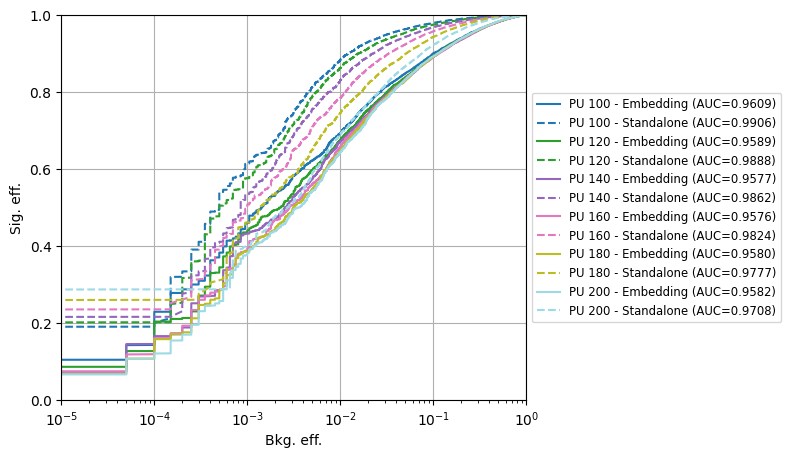

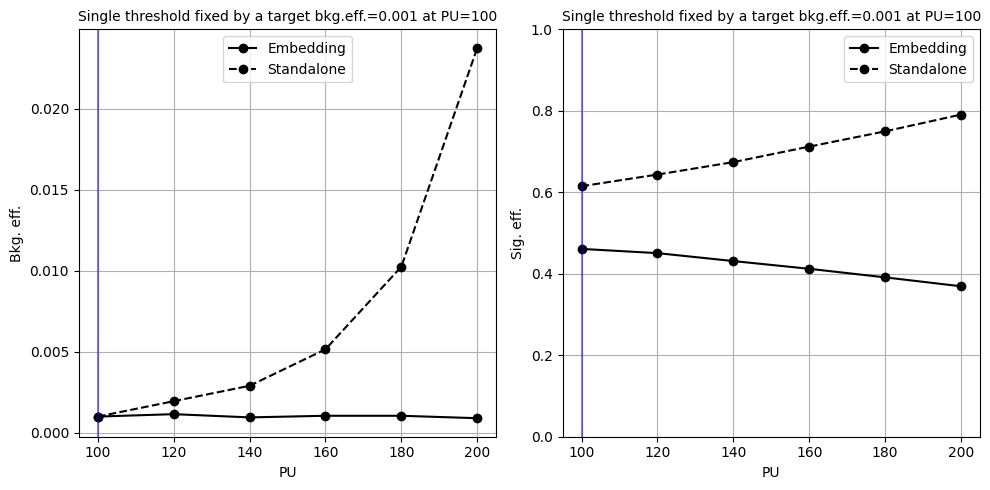

In [87]:
plot_roc(Y_test=Y_test, Y_pred_embedding=Y_pred_embedding, Y_pred_standalone=Y_pred_standalone, test_pu=test_pu)
#plot_sig_eff_vs_pu_at_single_bkgeff(Y_test=Y_test, Y_pred_embedding=Y_pred_embedding, Y_pred_standalone=Y_pred_standalone, test_pu=test_pu, bkg_eff_list=[0.05,0.1,0.2,0.5])
plot_eff_vs_pu_at_single_threshold(Y_test=Y_test, Y_pred_embedding=Y_pred_embedding, Y_pred_standalone=Y_pred_standalone, test_pu=test_pu, threshold_by_target_bkgeff_pu=[0.001, 100])